# **Consommation et revenu disponible brut des ménages français depuis 1949**

Il est temps de mettre en pratique ce qui a été vu sur les séries temporelles via un petit projet guidé d'analyse de séries temporelles.

L'objectif est de s'intéresser à la relation entre les dépenses de consommation et le revenu disponible des ménages en France. Pour ce faire, on distinguera trois parties :
1. [l'acquisition des données](#donnees)
2. [la modélisation univariée à partir d'une spécification ARIMA](#arima)

Vous trouverez dans le dossier data, les series suivantes nécéssaires à votre travail :
- la série de [consommation des ménages aux prix courants](https://www.insee.fr/fr/statistiques/4485021?sommaire=4485040)
- la série du [revenu disponible brut des ménages aux prix courants](https://www.insee.fr/fr/statistiques/4485029?sommaire=4485040) (souvent abrégé *RDB*)
- vous aurez également besoin des [indices de prix à la consommation](https://www.insee.fr/fr/metadonnees/source/indicateur/p1653/description) pour transformer en valeurs réelles les séries qui sont en valeurs nominales.

<a id="donnees"></a>

## **Partie 1 - Les données**

In [3]:
#vos imports
import fonctions as fct
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import shapiro
import warnings ; warnings.filterwarnings(action='ignore') #pour ignorer les warnings : privilégier en général action="once" pour n'avoir qu'une fois les warnings

C:\Users\luca5\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### **Question 1.1**

Importer les 2 séries en gérant bien les dates afin d'avoir un DatetimeIndex de frequence trimestriel.

In [4]:
conso = pd.read_csv("data/conso.csv", decimal=",", index_col="t",
                    parse_dates=True,
                    date_parser=lambda s: pd.to_datetime(s.replace("T", "Q")))
conso.asfreq("QS").index

DatetimeIndex(['1949-01-01', '1949-04-01', '1949-07-01', '1949-10-01',
               '1950-01-01', '1950-04-01', '1950-07-01', '1950-10-01',
               '1951-01-01', '1951-04-01',
               ...
               '2016-10-01', '2017-01-01', '2017-04-01', '2017-07-01',
               '2017-10-01', '2018-01-01', '2018-04-01', '2018-07-01',
               '2018-10-01', '2019-01-01'],
              dtype='datetime64[ns]', name='t', length=281, freq='QS-JAN')

In [5]:
conso

,conso
t,
1949-01-01,1.9
1949-04-01,2.0
1949-07-01,2.1
1949-10-01,2.1
1950-01-01,2.1
...,...
2018-01-01,303.4
2018-04-01,304.2
2018-07-01,306.5


In [6]:
conso.index = pd.date_range(start="1949", periods=281, freq='Q')

### **Question 1.2**

Qu'appelle-t-on "valeur nominale" et "valeur réelle" ?  
En quelles valeurs sont les séries dont vous disposez ? La réponse est dans l'énoncé...  
Quelles valeurs vous paraissent plus adaptées au problème ?  
Faire la transformation nécessaire (vous disposez de la série des indices de prix à la consommation, ça peut servir)

<Axes: >

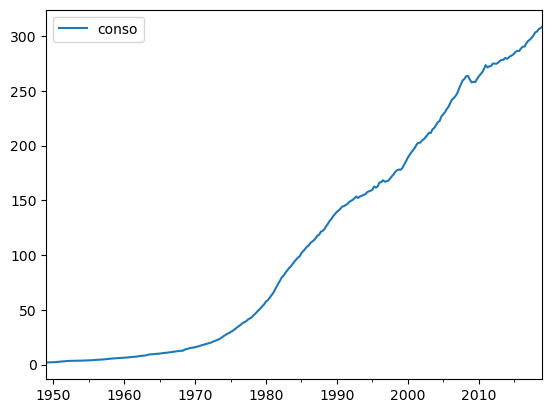

In [7]:
conso.plot()

In [8]:
rdb = pd.read_csv("data/revenu.csv", usecols=['rdb'], decimal=',', skipfooter=3)
rdb.index = pd.date_range(start="1949", periods=281, freq='Q')  

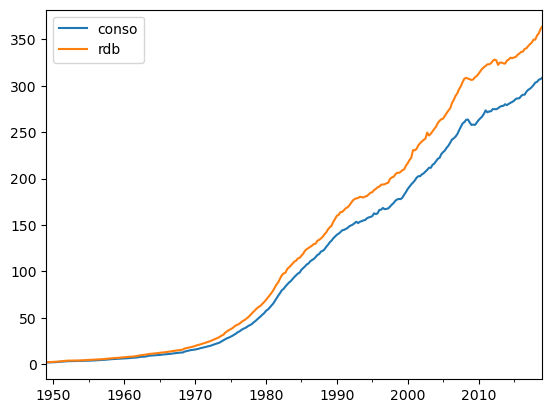

In [9]:
df = conso.copy()
df['rdb'] = rdb.values
df[['conso', 'rdb']].plot();

In [10]:
df["ipc"] = pd.read_csv('data/ipc.csv', usecols=['indice'], skipfooter=3).values
df

,conso,rdb,ipc
1949-03-31,1.9,2.3,5.07
1949-06-30,2.0,2.3,4.91
1949-09-30,2.1,2.4,5.15
1949-12-31,2.1,2.4,5.38
1950-03-31,2.1,2.5,5.46
...,...,...,...
2018-03-31,303.4,349.7,102.42
2018-06-30,304.2,354.2,103.07
2018-09-30,306.5,356.5,103.25
2018-12-31,307.3,361.2,103.16


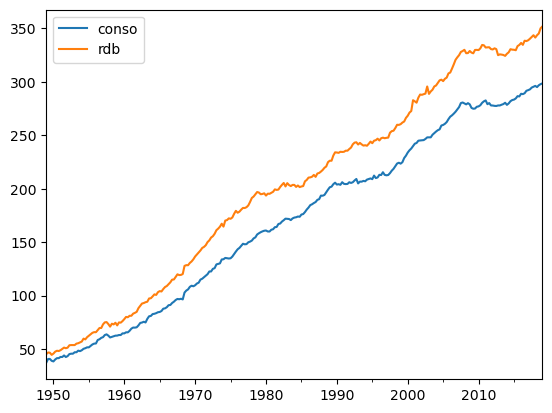

In [11]:
df['conso'] = df['conso']/df['ipc']*100
df['rdb'] = df['rdb']/df['ipc']*100
df[['conso', 'rdb']].plot();

### **Question 1.3**


Représentez graphiquement les 2 séries avec et sans transformation logarithmique.  
Que constate-t-on ?  
Laquelle vous semble-t-elle le plus adéquate ?

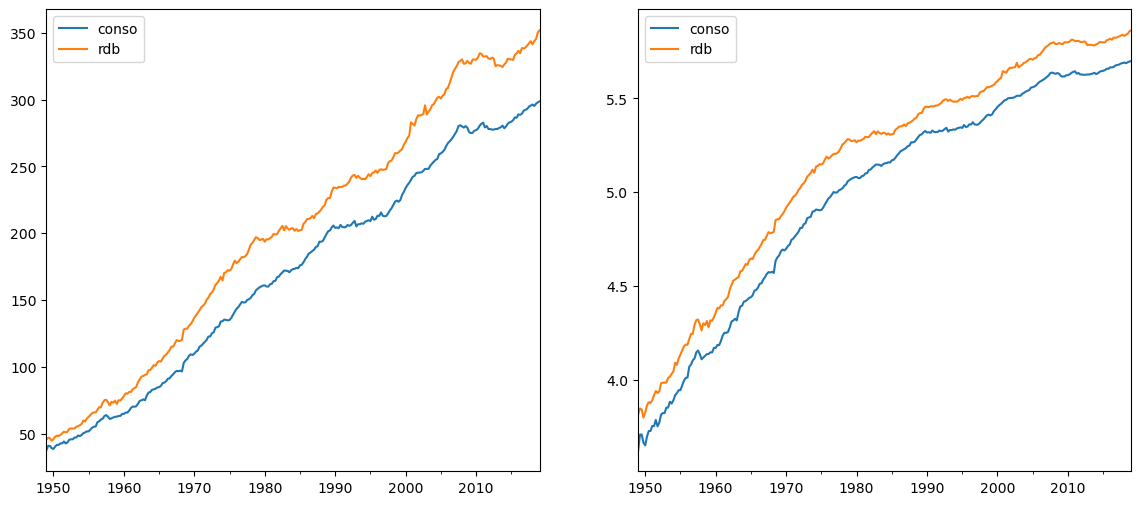

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
df[["conso", "rdb"]].plot(ax=ax1)
np.log(df)[["conso", "rdb"]].plot(ax=ax2);

### **Question 1.4**

La série est-t-elle stationnaire ?  
Pour ceux que ça intéresserait (y a un peu de maths derrière par contre...), il existe des tests pour déterminer si une série est stationnaire lorsque ce n'est pas évident graphiquement. Il en existe de 2 sortes :
- les tests de stationnarité, comme le test KPSS, pour lesquels l'hypothèse nulle $H_0$ est que la série est stationnaire
- les tests de racine unitaire comme le test de Dickey-Fuller, le test augmenté de Dickey-Fuller (ADF), ou encore le test de Phillips-Perron (PP) pour lesquels l'hypothèse nulle $H_0$ est que la série a été générée par un processus présentant une racine unitaire, et donc, qu'elle n'est pas stationnaire

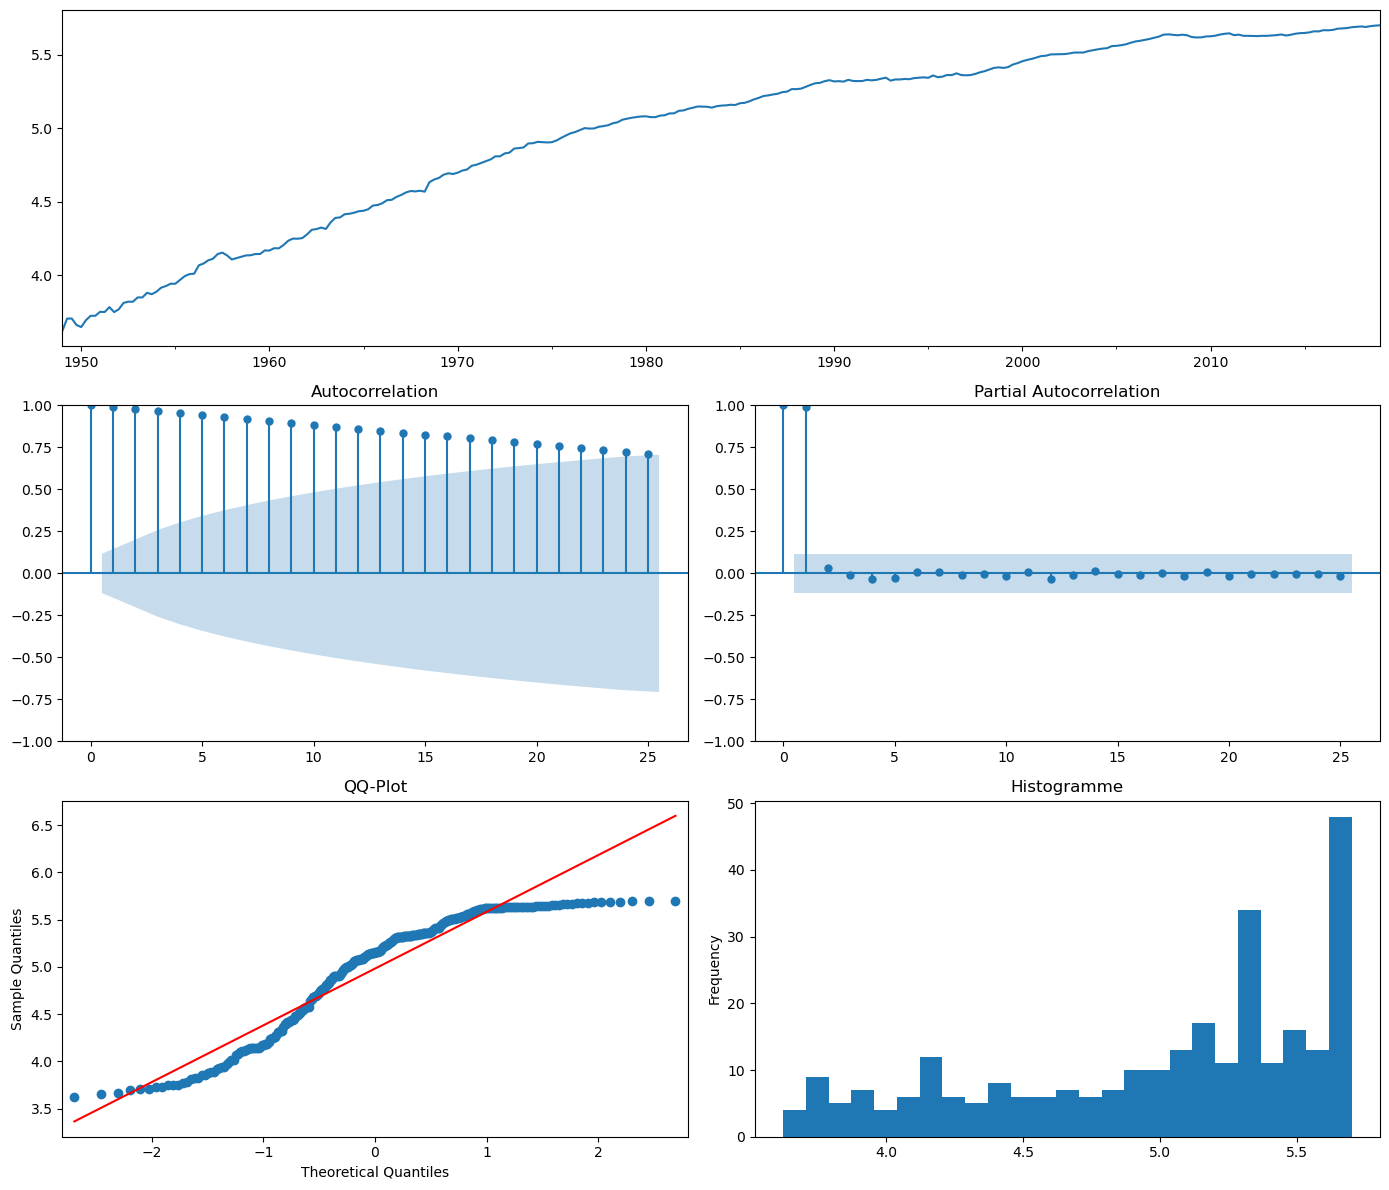

In [28]:
logC = np.log(df.conso)
fct.ts_plot(logC)

In [35]:
print(f"Test KPSS : HO='série stationnaire' : p-value = {smt.stattools.kpss(logC)[1]} < 0.05, on ne rejette H0",
      f"\nTest ADF : HO='série non stationnaire' : p-value = {smt.stattools.adfuller(logC)[1]} < 0.05 on rejette H0")

Test KPSS : HO='série stationnaire' : p-value = 0.01 < 0.05, on rejette H0 
Test ADF : HO='série non stationnaire' : p-value = 4.314985207687807e-07 > 0.05 on ne rejette pas H0


<a id="arima"></a>

## **Partie 2 - Modèle ARIMA**

Il est temps de modéliser ces séries par un modèle ARIMA : dans un premier temps, la série consommation puis il conviendra de répéter les opérations pour la série revenu disponible.

### **Question 2.1**

Se ramener à une série stationnaire par différenciation.

Test KPSS : HO='série stationnaire' : p-value = 0.01 
Test ADF : HO='série non stationnaire' : p-value = 0.028336611337234814


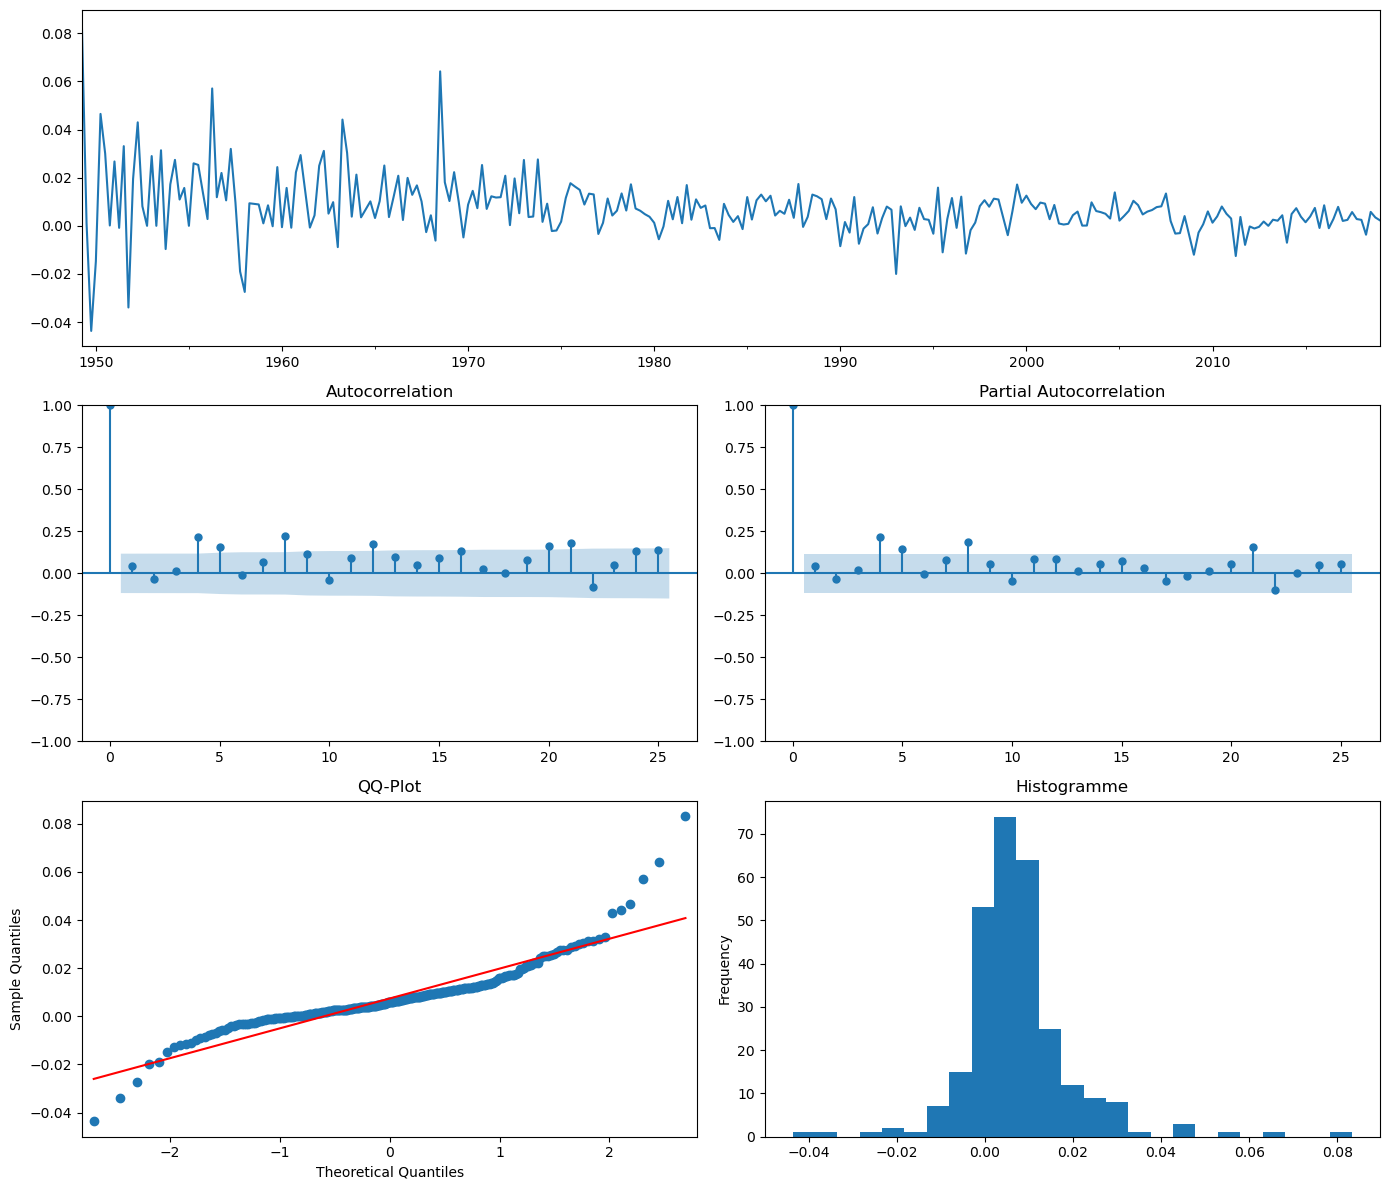

In [40]:
logC_diff = logC.diff()[1:]

print(f"Test KPSS : HO='série stationnaire' : p-value = {smt.stattools.kpss(logC_diff)[1]}",
      f"\nTest ADF : HO='série non stationnaire' : p-value = {smt.stattools.adfuller(logC_diff)[1]}")

fct.ts_plot(logC_diff)

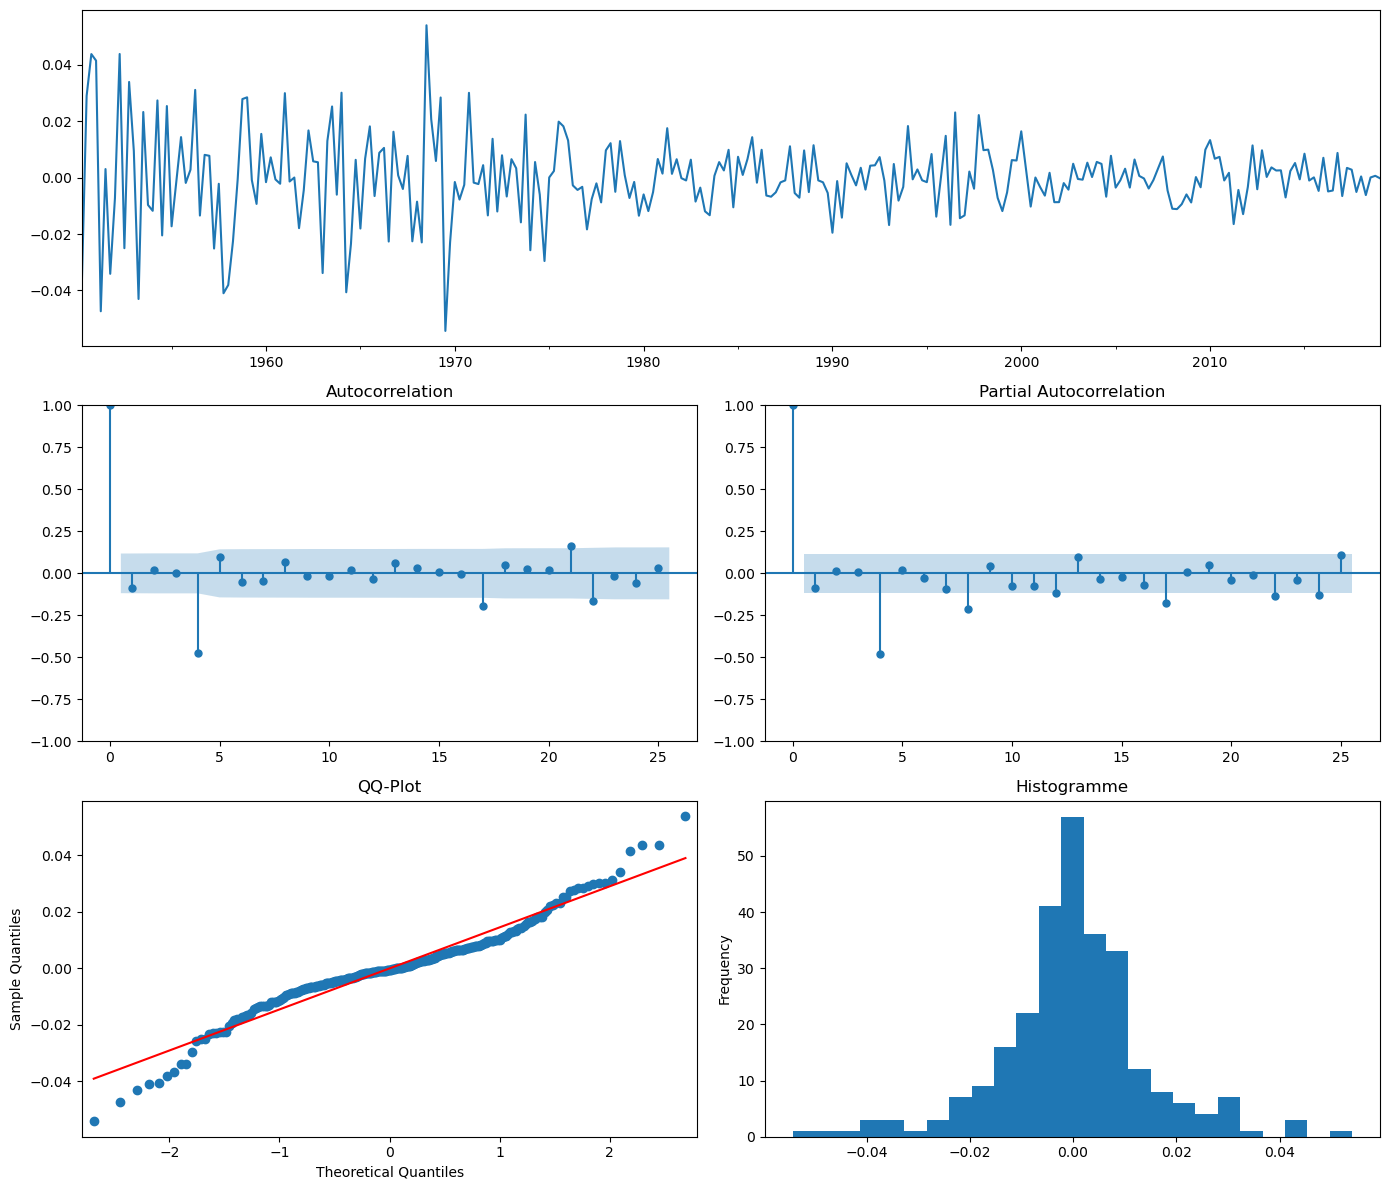

In [41]:
logC_diff4 = logC_diff.diff(4)[4:]

fct.ts_plot(logC_diff4)

### **Question 2.2**

Proposer un ordre de grandeur maximum pour les parties *autorégressive* et *moyenne mobile*, c'est-à-dire pour les valeurs $p_{max}$ et $q_{max}$ du modèle $ARMA(p,q)$.

**Indication :** La détermination de bornes supérieures concernant l'ordre de la partie AR et de la partie MA passe par l'étude des autocorrélogrammes et des autocorrélogrammes partiels. En effet, si la série suit un modèle $ARMA(p,q)$, l'autocorrélogramme devient nul à partir du rang $q$ et l'autocorrélogramme partiel devient nul à partir du rang $p$. Dès lors, en se basant sur les autocorrélogrammes, il est possible de déterminer empiriquement les ordres maximum en regardant à partir de quel rang les autocorrélogrammes sont statistiquement nuls.

### **Question 2.3**

Déterminer, à l'aide du critère $AIC$ (vous pouvez aussi utiliser le critère $BIC$), le ou les modèles les plus pertinents.

D'abord petit exemple de Grid Search avec Cross Validation, à l'aide du package sktime

In [42]:
data_train = logC[:'2010']
data_test = logC['2010':]
print(len(data_train))

248


Pour comprendre [ExpandingWindowSplitter](https://sktime-backup.readthedocs.io/en/v0.11.4/api_reference/auto_generated/sktime.forecasting.model_selection.ExpandingWindowSplitter.html)

In [51]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.arima import ARIMA
from sktime.split import ExpandingWindowSplitter

p = range(3)
d = range(1,2)
q = range(3)

params = itertools.product(p, d, q)
param_grid = {'order': list(params)}

# Ces paramètres donnent 4 splits avec nos 248 points de données
tscv = ExpandingWindowSplitter(initial_window=180, step_length=5, fh=50) 

forecaster = ARIMA()

grid_search = ForecastingGridSearchCV(forecaster, param_grid=param_grid, cv=tscv)

grid_search.fit(data_train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=50, initial_window=180,
                                                   step_length=5),
                        forecaster=ARIMA(),
                        param_grid={'order': [(0, 1, 0), (0, 1, 1), (0, 1, 2),
                                              (1, 1, 0), (1, 1, 1), (1, 1, 2),
                                              (2, 1, 0), (2, 1, 1),
                                              (2, 1, 2)]})

La MAPE est utilisé comme paramètre de scoring pour le [ForecastingGridSearchCV](https://sktime-backup.readthedocs.io/en/latest/api_reference/auto_generated/sktime.forecasting.model_selection.ForecastingGridSearchCV.html) par défaut.

Utiliser l'AIC n'est pas pertinent ici car 2 AIC sont comparables si elles ont été calculées sur les mêmes observations.

In [52]:
print(grid_search.get_fitted_params())

{'intercept': 0.009156746495384099, 'ar.L1': -0.053575859158501965, 'ar.L2': -0.0694988716348829, 'ma.L1': 0.08859813524059099, 'sigma2': 0.0001665021665798646, 'aic': -1438.0267170033767, 'aicc': -1437.777754347775, 'bic': -1420.4797753202367, 'hqic': -1430.9621809302128, 'order': (2, 1, 1), 'best_forecaster': ARIMA(order=(2, 1, 1)), 'best_index': 7, 'best_params': {'order': (2, 1, 1)}, 'best_score': 0.03444134882075575, 'cv_results':    mean_test_MeanAbsolutePercentageError  mean_fit_time  mean_pred_time  \
0                               0.034514       0.247655        0.067454   
1                               0.034495       0.622898        0.050633   
2                               0.034521       0.822711        0.053626   
3                               0.034458       0.550018        0.058954   
4                               0.034475       0.601882        0.050137   
5                               0.034690       1.096087        0.038600   
6                               0.0

Fin de la parenthèse, cherchons des paramètres idéaux pour SARIMA grâce à l'AIC

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = q = P = Q = range(3)
params = list(itertools.product(p, q, P, Q))
from ipywidgets import IntProgress

from IPython.display import display
progressbar = IntProgress(min=0, max=len(params))
display(progressbar)

best_aic = np.inf
best_pdq = None
best_PDQ = None
tmp_model = None
best_model = None

for p,q,P,Q in params:
    try:
        tmp_model = SARIMAX(logC,
                            order = (p,1,q),
                            seasonal_order = (P,1,Q,4))
        res = tmp_model.fit(disp=False)
        
        progressbar.value += 1
        
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p,1,q)
            best_PDQ = (P,1,Q)
            best_model = tmp_model
    except:
        print("Erreur:", sys.exc_info()[1])
        continue
            
print("Modèle retenu : SARIMA{}{}4 - AIC:{}".format(best_pdq, best_PDQ, best_aic))

Modèle retenu : SARIMA(0, 1, 0)(0, 1, 1)4 - AIC:-1675.5604529993966

### **Question 2.4**

Pour valider les modèles  retenus, il reste deux critères à regarder :
1. regarder la significativité des coefficients
2. examiner la "blancheur" des résidus

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model2 = SARIMAX(logC, order=(0,1,0), seasonal_order=(0,1,1,4)).fit(disp=False)
print(model2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               conso   No. Observations:                  281
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 839.780
Date:                             Thu, 20 Jun 2024   AIC                          -1675.560
Time:                                     16:50:47   BIC                          -1668.320
Sample:                                 03-31-1949   HQIC                         -1672.655
                                      - 03-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L4       -0.8247      0.038    -21.524      0.000      -0.900      -0.750
sigma2         0.0001   6.4

Test de Shapiro : ShapiroResult(statistic=0.08638966678593873, pvalue=1.5799215273716438e-34)


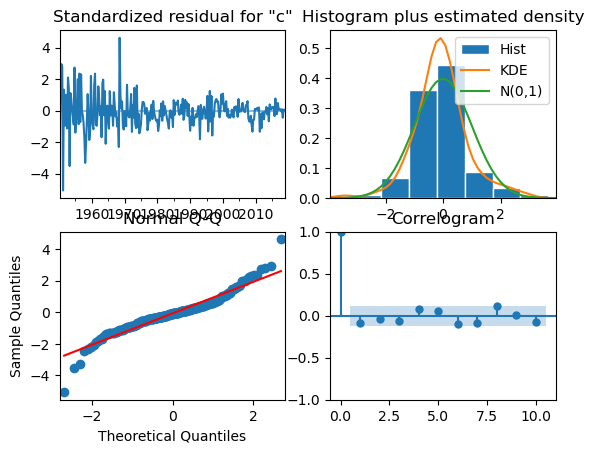

In [57]:
model2.plot_diagnostics();
err2 = model2.resid
#normalité
print(f"Test de Shapiro : {shapiro(err2)}")

### **Question 2.5**

Répéter l'analyse pour la série des revenus disponibles.

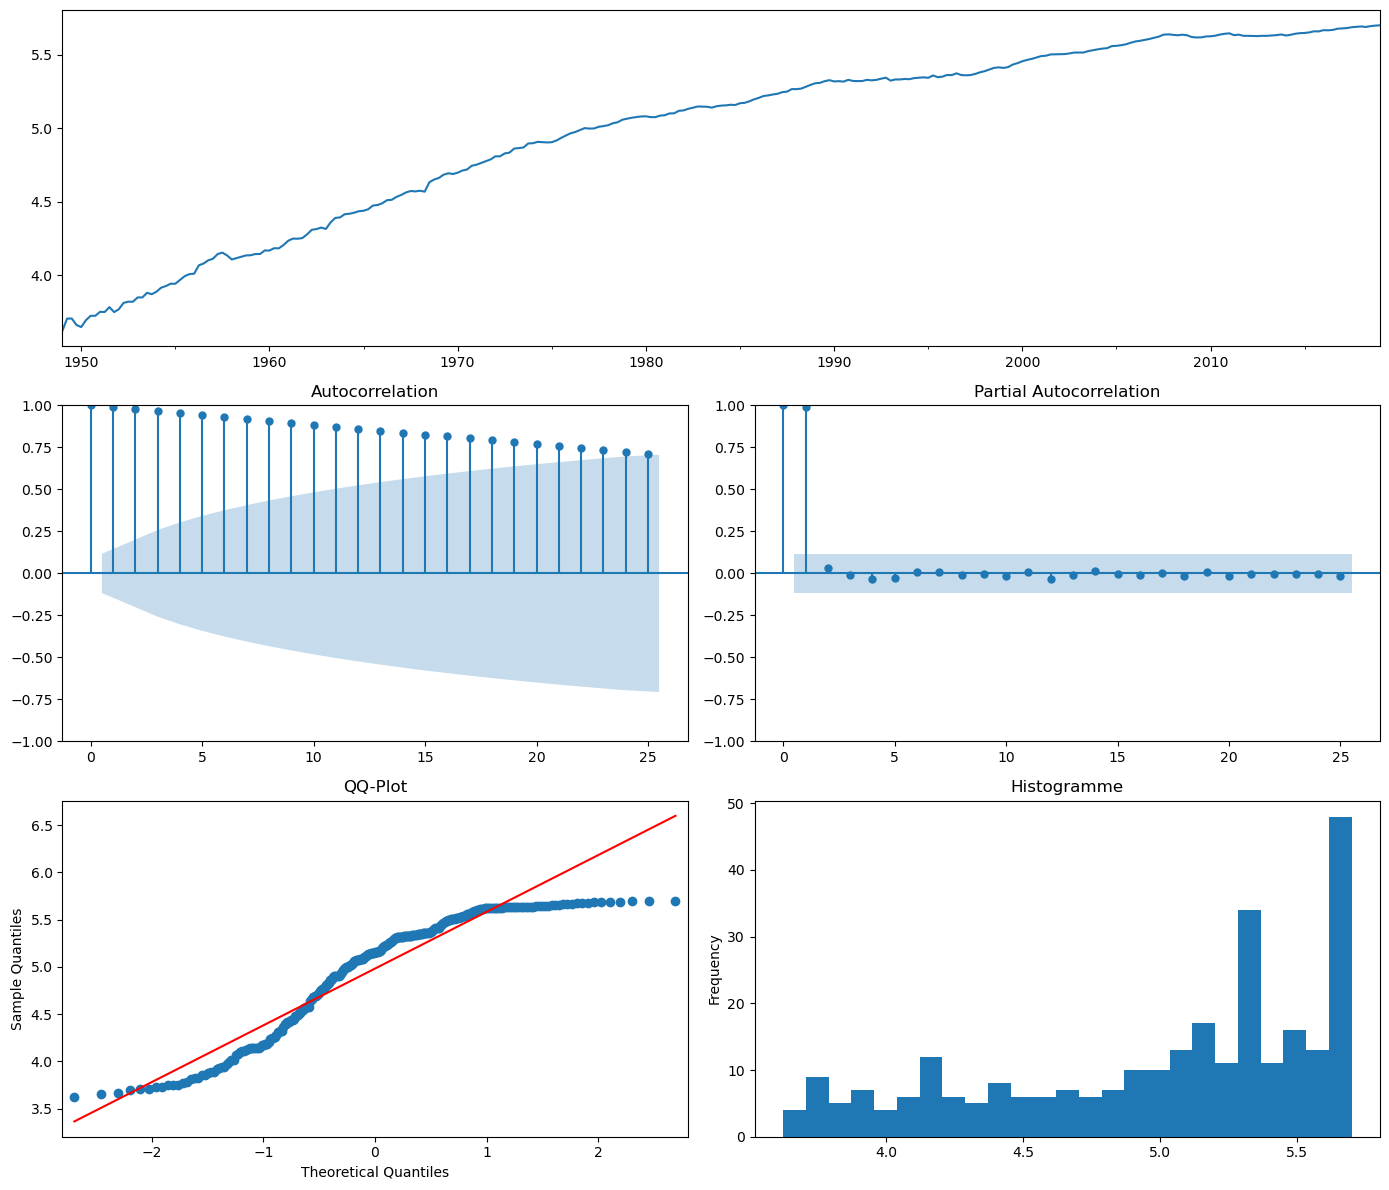

In [58]:
logR = np.log(df.rdb)
fct.ts_plot(logC)

Test KPSS : HO='série stationnaire' : p-value = 0.01 
Test ADF : HO='série non stationnaire' : p-value = 0.010763127217824069


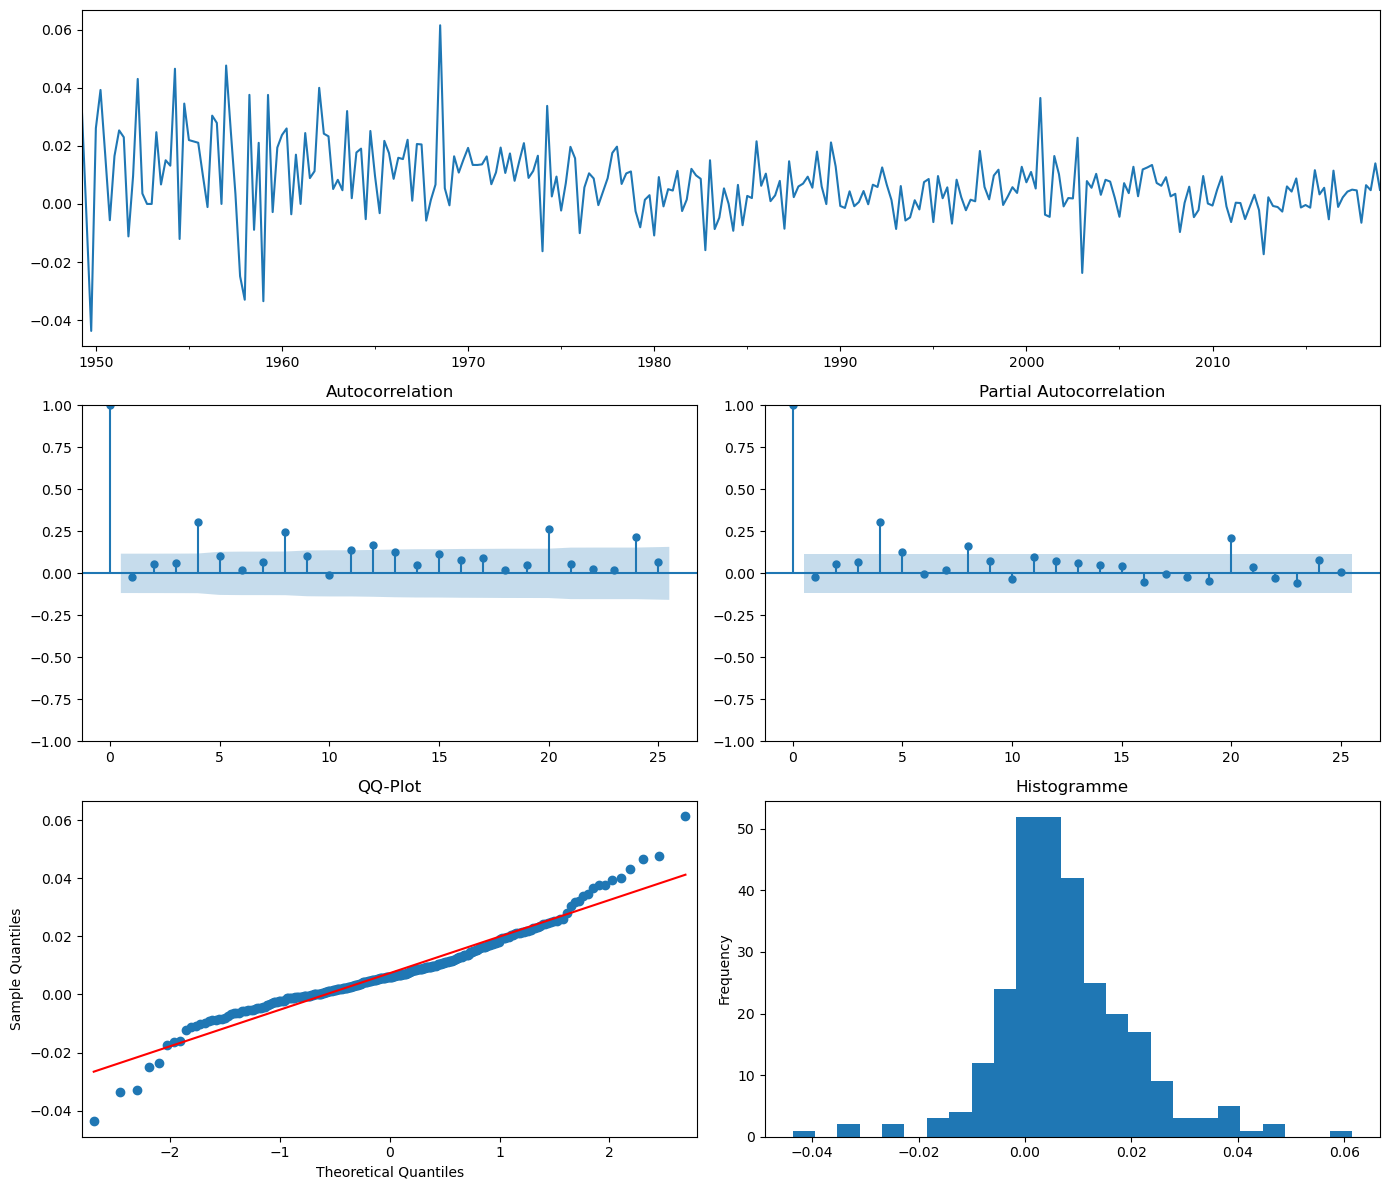

In [59]:
logR_diff = logR.diff()[1:] #pareil que logC - logC.shift(1)

print(f"Test KPSS : HO='série stationnaire' : p-value = {smt.stattools.kpss(logR_diff)[1]}",
      f"\nTest ADF : HO='série non stationnaire' : p-value = {smt.stattools.adfuller(logR_diff)[1]}")

fct.ts_plot(logR_diff)

Test KPSS : HO='série stationnaire' : p-value = 0.1 
Test ADF : HO='série non stationnaire' : p-value = 7.887069906832316e-09


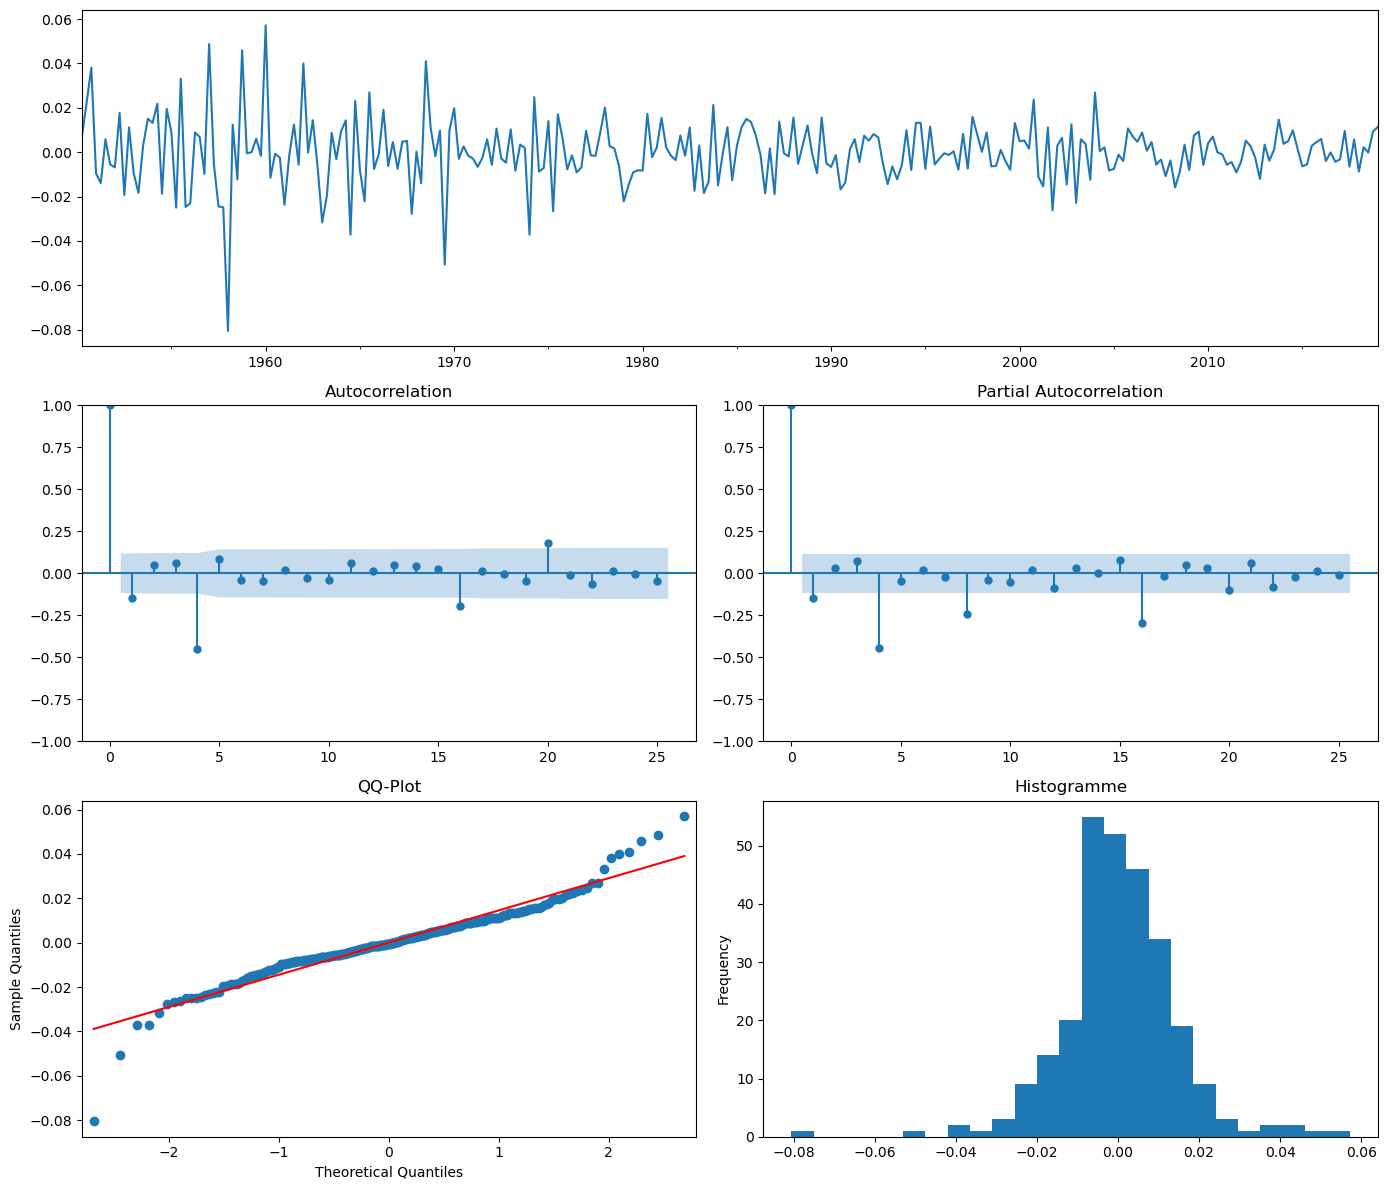

In [60]:
logR_diff4 = logR_diff.diff(4)[4:]

print(f"Test KPSS : HO='série stationnaire' : p-value = {smt.stattools.kpss(logR_diff4)[1]}",
      f"\nTest ADF : HO='série non stationnaire' : p-value = {smt.stattools.adfuller(logR_diff4)[1]}")

fct.ts_plot(logR_diff4)

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = q = P = Q = range(3)
params = list(itertools.product(p, q, P, Q))
from ipywidgets import IntProgress

from IPython.display import display
progressbar = IntProgress(min=0, max=len(params))
display(progressbar)

best_aic = np.inf
best_pdq = None
best_PDQ = None
tmp_model = None
best_model = None

for p,q,P,Q in params:
    try:
        tmp_model = SARIMAX(logR,
                            order = (p,1,q),
                            seasonal_order = (P,1,Q,4),
                            enforce_stationarity=True,
                            enforce_invertibility=True)
        res = tmp_model.fit(disp=False)
        
        progressbar.value += 1
        
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p,1,q)
            best_PDQ = (P,1,Q)
            best_model = tmp_model
    except:
        print("Erreur:", sys.exc_info()[1])
        continue
            
print("Modèle retenu : SARIMA{}{}4 - AIC:{}".format(best_pdq, best_PDQ, best_aic))

IntProgress(value=0, max=81)

Modèle retenu : SARIMA(1, 1, 0)(0, 1, 1)4 - AIC:-1670.222320866671


                                      SARIMAX Results                                      
Dep. Variable:                                 rdb   No. Observations:                  281
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 838.111
Date:                             Thu, 20 Jun 2024   AIC                          -1670.222
Time:                                     17:09:43   BIC                          -1659.361
Sample:                                 03-31-1949   HQIC                         -1665.864
                                      - 03-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1691      0.056     -3.034      0.002      -0.278      -0.060
ma.S.L4       -0.8085      

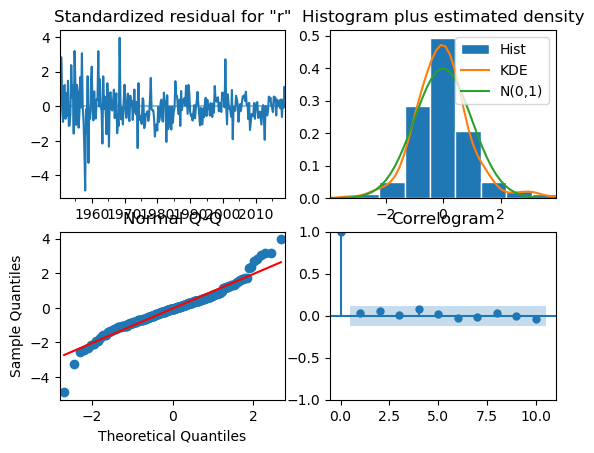

In [62]:
model2_R = SARIMAX(logR, order=(1,1,0), seasonal_order=(0,1,1,4)).fit(disp=False)
print(model2_R.summary())

err2_R = model2_R.resid

#stationnarité
print(f"Test KPSS : HO='série stationnaire' : p-value = {smt.stattools.kpss(err2_R)[1]}",
      f"\nTest ADF : HO='série non stationnaire' : p-value = {smt.stattools.adfuller(err2_R)[1]}")

#normalité
print(f"Test de Shapiro : {shapiro(err2_R)}")

#afficher les erreurs
model2_R.plot_diagnostics();

<a id="extra"></a>

## **Partie 3 (optionnel non corrigé) - Cointégration et modèle à correction d'erreur**

On s'intéresse dans cette partie au lien qu'il semble exister entre nos deux séries. En effet, graphiquement, les 2 séries ont l'air d'être liées par une relation de long terme. Plus spécifiquement, on suppose ici qu'il existe une éventuelle relation de **cointégration** de manière à mettre en place, par la suite, un modèle à **correction d'erreur**, ce qu'on ne fera pas ici.

On parle de cointégration lorsque les deux séries sont intégrées d’ordre 1 (c'est-à-dire que leur différenciation une fois : la série $x_t-x_{t-1}$ est stationnaire) et qu'il existe une relation linéaire entre les deux qui soit non intégrée (ou encore intégrée d'ordre zéro ou stationnaire, tout ça c'est à peu près pareil).

Sans forcément aller trop loin sur la partie théorique, juste 2 petites questions guidées permettent de regarder en pratique un début de ce qu'est la cointégration des séries.

### **Question 3.1**

Sous réserve de validation, la relation de long-terme est modélisée par un modèle linéaire. On va commencer par effectuer une régression linéaire de la série consommation, notée $C_t$ sur la série revenu disponible notée $R_t$ (avec ou sans transformation logarithmique selon l'étude qui a précédée) :

$$C_t = \beta_0 + \beta_1 R_t + z_t$$

Utiliser pour cette régression la libraire `statsmodel` afin afficher le `summary` de la régression puis commenter les résultats (notamment la significativité et les valeurs des coefficients)

### **Question 3.2**

Pour valider le modèle de cointégration, les résidus $z_t$ de la régression linéaire doivent être stationnaire. On peut regarder déjà graphiquement ce qu'il en est. Commenter le résultat.

Sans entrer dans le détail des tests de stationnarité évoqués précédemment, un peut utiliser par exmple la fonction `adfuller` du module `statsmodels.tsa.stattools` pour vérifier si la série est stationnaire. L'hypothèse nulle $H_0$ du test ADF est que la série admet ce qu'on appelle une racine unitaire et donc que la série n'est pas stationnaire.

**Pour aller plus loin :** si vous souhaitez pousser l'analyse, vous pouvez vous intéresser à ce qu'on appelle un modèle à correction d'erreurs et essayer de comprendre la notion de vitesse d'ajustement. Pour cela, il faut, entre autres, modéliser les résidus par un processus $ARMA$.